# Independent Component Analysis (ICA)

In the last lecture we looked at PCA which seeks a new orthogonal basis, which rotates data into a new frame of reference, whose coordinate bases more accurately align with the main directions of variance in the data.

In this lecture we discuss Independent Component Analysis or ICA. Rather than searching for an orthogonal basis this method searches for a basis whose eigenvectors are maximally independent (or minimally correlated) from one another.

Starting by importing key modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
from scipy import signal
from scipy.io import wavfile

%matplotlib inline 

## The Cocktail Party Problem

ICA is commonly viewed as a technique for blind source separation. This concept is commonly explained through description of the 'Cocktail Party Problem.' 

Here, we assume that we record audio from several microphones, placed at different locations, in a room with many different sources of sound i.e. a room of people talking. Each microphone will record a different mixture of sounds. The goal of blind source separation is to recover the original sources. 

For example, lets pick an example of two different mixtures of audio files.

First play audio file one:

In [2]:
IPython.display.Audio("Data/mix1.wav")

Now audio file two:

In [3]:
IPython.display.Audio("Data/mix2.wav")

Our goal is to unmix these signals such that we recover the original sources i.e.:

In [4]:
IPython.display.Audio("Data/source1.wav")

In [5]:
IPython.display.Audio("Data/source2.wav")

## Defining ICA

We seek to separate our sources using ICA. ICA is a matrix factorisation approach; it represents a linear model where the original data $\mathbf{X}$ may be represented as a combination of independent source signals $\mathbf{S}$ and mixing coefficients $\mathbf{A}$ such that $\mathbf{X=AS}$. i.e. for one microphone $m$ the mixed signal received at each point in time is written as:

$$ X^m(t)=\sum_i^n A_i^m S_i(t) $$

Here, n represents the number of sources estimated. Thus, for the above example with two source signals, the signal received for mixture 1, at time point 1, is a weighted sum of contributions from each of the sources at the equivalent point in time. The weights are given by the coefficient matrix $\mathbf{A}$, where each row reflects the coefficients for a different mixture.

Our goal through application of ICA is therefore to find the matrix $\mathbf{A}^{-1}$ that un-mixes the independent source $\mathbf{S}$:

$$ \mathbf{S}=\mathbf{A^{-1}X}=\mathbf{WX}$$

Where from now on we refer to the unmixing matrix $\mathbf{A}^{-1}$ as $\mathbf{W}$.

## Solving for ICA

Solutions for ICA assume:
- The source signals are independent of each other.
- The values in each source signal have non-Gaussian distributions

### What do we mean by independence?

One way to solve for $\mathbf{W}$ is to optimise so as to maximise the independence of the recovered source signals. But what do we mean by independent signals?

Two events or timeseries A and B are defined as independent if:
- Information on the value of A does not give any information on the value of B, and vice versa. 
- The joint probability equals the product of their probabilities: $P(A\cap B)=P(A)P(B)$

The latter constraint can be rewritten as requiring:

$$P(A)=\frac{P(A\cap B)}{P(B)} = P(A|B)$$

Thus when the joint probability is equal to the product of the marginals the conditional probability of A given B is equal to the marginal probability of A  and thus A is independent of B

### Why non-gaussian?

Let's say that our sources come from 2 Gaussian signals with unit variance: $S \sim  \mathcal{N}(0,I)$:

<img src="imgs/signal_with _diagonal_covariance.png" style="max-width:100%; width: 25%; max-width: none">

i.e. S will have a circular distribution centered on origin. In this case $\mathbf{X=AS}$ is also Gaussian with zero mean and covariance since:

$$ E[\mathbf{XX^T}]= E[\mathbf{ASS^TA^T}]= \mathbf{AA^T} $$

where we use $\mathbf{SS^T=I}$ as the S are independent and thus orthogonal. 

Our goal with ICA is to be able to predict unique sources. However, if the original source signals our Gaussian we can imagine a situation where we propose a new coefficients matrix $\mathbf{A}$ through a rotation $\mathbf{R}$ (where by definitation $\mathbf{RR^T=R^TR=I}$), such that $\mathbf{A'=AR}$. 

Thus we observe the effect of a new combination of coefficients: $\mathbf{A'}$ instead of A $\mathbf{R}$, which, if we are to be able to distinguish their effect through a new mixture $\mathbf{X'=A'S}$, we would require that the distribution we observe with $\mathbf{X'}$ differs from that of $\mathbf{X}$. Unfortuntely, in the case of Gaussian variables however, this becomes impossible. The distribution of $\mathbf{X'}$ is also Gaussian with zero mean and unit covariance:

$$ E[\mathbf{X'X'^T}]= E[\mathbf{A'SS^TA'^T}]= E[\mathbf{ARSS^TR^TA^T}]= \mathbf{ARR^TA^T} = \mathbf{AA^T}$$

If we cannot find a unique A then we cannot find a unique W and we cannot recover the original sources. Thus, signals must be non-Gaussian. 

## FastICA

Through using these two assumptions we can solve the ICA problem using a variety of approaches. In this lecture, however, we will focus on FastICA [Hyv2000].

This approaches the problem in two stages:
- Pre-whitening
- Iterative component extraction


### Pre-whitening (proof is not examinable)

Pre-weightening is related to PCA and refers to the transformation of the data covariance matrix from $\mathbf{X}$ to $\mathbf{Y}$ such that it has zero mean and unit covariance (i.e. $cov(\mathbf{Y})=\mathbf{I}$). This is performed so as to transform the required mixing matrix into an orthogonal matrix reducing the number of parameters that needs to be estimated.

Whitening is performed by first demeaning the data matrix s.t. $x_{ij} \leftarrow x_{ij}-\frac{1}{M}\sum_j x_{ij}$. Then data $\mathbf{X}$ is transformed into $\mathbf{Y}$ through singular value decomposition of the original covariance matrix $\mathbf{\Sigma} = Cov(\mathbf{X})= \mathbf{EDE^{-1}}$. Specifically, rewriting:

$$\mathbf{\Sigma} = \mathbf{EDE^-1} \rightarrow \mathbf{D} = \mathbf{E^{-1}\Sigma E} $$

We want: $\mathbf{Y}=\mathbf{W_wX}$, where $Cov(\mathbf{Y})=\mathbf{I}$ and $\mathbf{W_w}$ is the transformation matrix.

From the standard definition that $\mathbf{D}$ multiplied by its inverse is the identity ($\mathbf{DD^1=I}$, we can define:

$$\mathbf{D^{-1}D} = \mathbf{D^{-1}E^{-1}\Sigma E} \rightarrow  \mathbf{I} = \mathbf{D^{-1}E^{-1}\Sigma E} $$

Rewriting $\mathbf{D^{-1}}$ as $\mathbf{D^{-1/2}D^{-1/2}}$ and reordering (this is possible since both $\mathbf{D}$ and $\mathbf{D^{1/2}}$ are diagonal matrices:

$$ \mathbf{I} = \mathbf{D^{-1/2}E^{-1}\Sigma E D^{-1/2}} $$

We need the covariance (rewritten in terms of W and X) to be the identity:

$$ Cov(\mathbf{Y}) = (1/n) \mathbf{W_wXX^TW_w^T}= \mathbf{I}$$

We know the above expression in $\mathbf{D}$ is equal to the identity. We can therefore substitute for I:

$$  (1/n) \mathbf{W_wXX^TW_w^T}= \mathbf{D^{-1/2}E^{-1}\Sigma E D^{-1/2}} $$

Replace $\mathbf{XX^T}/n$ as $\mathbf{Sigma}$:

$$  (1/n) \mathbf{W_w\Sigma W_w^T}= \mathbf{D^{-1/2}E^{-1}\Sigma E D^{-1/2}} $$

Then, from the symmetry on left and right sides, you can see that this means that $\mathbf{D^{-1/2}E^{-1}}$ must equal $\mathbf{W_w}$. Finally we can write as $\mathbf{W_w=D^{-1/2}E^T}$, since $\mathbf{E^T}=\mathbf{E^{-1}}$, since as an eigenvector, it is a orthonormal. 

Thus, essentially whitening performs the following transformations:

<img src="imgs/whitening.png" style="max-width:100%; width: 10%; max-width: none">

First multiplication by eigenvectors $\mathbf{E}$ decorrelate the data (thought of as a rotation that reorients the data so that the principal axes of the data are aligned with the axes along which the data has the largest (orthogonal) variance). Then data variance is squeezed along a dimensions where it is larger than one, and stretched along dimensions where it is less than one.

Typically W is also premultiplied by $\mathbf{E^{-1}}$ in order to rotate data back to its original space. Thus we define:

$$\mathbf{W_w=E^{-1}D^{-1/2}E^T} $$

## Exercise 1: implement pre-whitening in numpy

Given the above definition for the whitening transform $\mathbf{W_w}$, estimate the whitening transform of a sample data matrix $\mathbf{X}$

 __Task 1__: The code below loads the signals from the mixed audio files demoed above. Run the code and fill the code to visualise the signals.

Sampling rate =  8000
Data type is  uint8
Sampling rate =  8000
Data type is  uint8
Shape of the matrix X is (2, 50000)


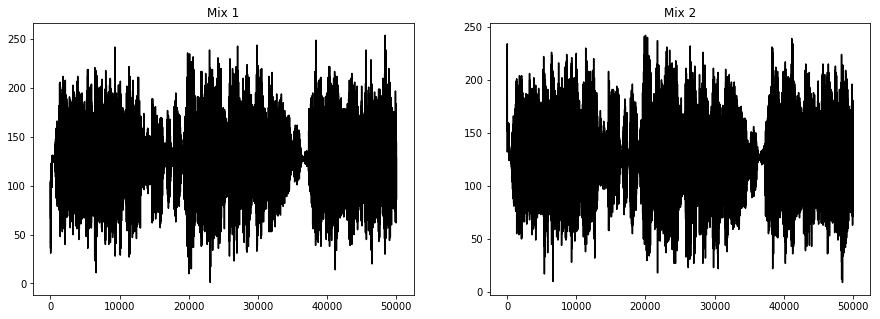

In [6]:
# load mixed audio files (sampled above) and use these to define a data matrix X

# Load first signal
samplingRate, signal1 = wavfile.read('Data/mix1.wav')
print("Sampling rate = ", samplingRate)
print("Data type is ", signal1.dtype)

# Plot first signal
plt.figure(figsize = [15,5])
plt.subplot(121)
plt.plot(signal1,'k')
plt.title('Mix 1')

# Load second signal
samplingRate, signal2 = wavfile.read('Data/mix2.wav')
print("Sampling rate = ", samplingRate)
print("Data type is ", signal2.dtype)

# Plot second signal
plt.subplot(122)
plt.plot(signal2,'k')
plt.title('Mix 2')

# input both signals into the matrix X
X= np.stack((signal1,signal2),axis=0) # mixed signals
# X is shape (m x t) where m is the number of mixtures and t is the number of time points
print('Shape of the matrix X is', X.shape)



__Task 2:__ Implement estimate the whitening transform from the SVD of the covariance of $\mathbf{X}$. 

To do that perform following tasks:
1. Calculate covariance matrix $\mathbf{\Sigma} = Cov(\mathbf{X})$. Use function `np.cov`. Verify that the dimension of covariance matrix is $2\times 2$.
2. Perform singular value decomposition $\mathbf{\Sigma} = \mathbf{EDE^{-1}}$ using function `np.linalg.svd` to estimate eigenvectors and eigenvalues of $\mathbf{\Sigma}$. Numpy returns the singular values `D` as a vector, we need to convert to a matrix using `np.diag`.
3. Estimate whitening matrix $\mathbf{W_w=E^{-1}D^{-1/2}E^T}$: 
    * to invert matrix $E$ use `np.linalg.inv`
    * to calculate $D^{-1/2}$ use `fractional_matrix_power`
    * to multiply three matrices together, use `np.linalg.multi_dot`

For further info check:
* https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.multi_dot.html
* https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.linalg.fractional_matrix_power.html

In [7]:
from scipy.linalg import fractional_matrix_power

# Step 1: estimate covariance matrix
covX=np.cov(X)
print('Dimension of the covariance matrix: ', covX.shape)

# Step 2: estimate eigenvalues and vectors of the covariance matrix using SVD

# E [M x M] eigenvectors of cov(X).
# S: [M x 1] eigenvalues of cov(X).
# E_trans: [M x M] transpose of E
E,D,E_trans=np.linalg.svd(covX)

# convert D (vector representing diagonal of singular value matrix) to a matrix
D_mat=np.diag(D)

# Step 3: estimate whitening matrix : E^-1 * D^-0.5 * E^T

# Invert matrix E
E_inv = np.linalg.inv(E)
# Calculate D^-0.5
D_invsqrt = fractional_matrix_power(D_mat, -0.5)
# multiply E^-1 * D^-0.5 * E^T
W_w=np.linalg.multi_dot([E_inv, D_invsqrt,E_trans])


print('Pre-withening matrix: ')
print(W_w)

Dimension of the covariance matrix:  (2, 2)
Pre-withening matrix: 
[[3.73929397e-02 3.06808770e-07]
 [3.06808770e-07 3.73266630e-02]]


__Task 3:__ Transform $X$ using the learnt transform $W_W$ to obtained the new covariance matrix  $\mathbf{Y}=\mathbf{W_wX}$. Print the new covariance matrix of the transformed data $\mathbf{Y}$ to verify that it has mean zero and unit variance: $cov(\mathbf{Y})=\mathbf{I}$.

In [8]:
Y=np.dot(W_w,X)
print('Dimension of transformed data is ', Y.shape)
print('The new covariance matrix is: \n {} '.format(np.cov(Y)))

Dimension of transformed data is  (2, 50000)
The new covariance matrix is: 
 [[ 1.00000000e+00 -8.81090614e-18]
 [-8.81090614e-18  1.00000000e+00]] 


## FastICA optimisation (optional)

Following whitening the FastICA algorithm proceeds to estimate components through optimising for non-Gaussianity. The motivation for this is the Central Limit Theorem, which states:

<center> "_The distribution of a sum of independent random variables tends toward a gaussian distribution_" <center>

<br>
In other words, a mixture of two independent random variables will have a distribution that is closer to Gaussian than that of either of the two original signals. 

Thus, we can use this to form the basis of an algorithm to separate the components. What we are looking for is for each source to be represented as a linear sum of the mixture components with coefficients given by the inverse of our mixing matrix $\mathbf{S}=\mathbf{A^{-1}X}= \mathbf{WX}$

We can try different linear combinations of mixtures $\mathbf{x}$ (where $\mathbf{x}$ is one row of $\mathbf{X}$) e.g.

$$\mathbf{y}= \mathbf{w^Tx}= \sum_i w_i x_i $$

knowing that when we get the right values for $\mathbf{w}$ then it will form a row of the un-mixing matrix $\mathbf{W}$. By re-writing $\mathbf{y}$ as:

$$\mathbf{y}= \mathbf{w^Tx}= \mathbf{w^TAs}= \mathbf{z^Ts} $$

We can see that, in fact, $\mathbf{y}$ can be shown to be a linear combination of the source signals, $\mathbf{s}$. $\mathbf{z^Ts}$ is least Gaussian when only one of the elements of \mathbf{z} is non-zero i.e. when it is equal to one of the source signals. Therefore, by seeking to maximise non-Gaussianity of $\mathbf{w^Tx}$ we can recover $\mathbf{s}$.

In FastICA maximal non-Gaussianty is, in fact, achieved by optimising to minimis the negatave (neg) entropy, since:

<center> "_a gaussian variable has the largest entropy among all random variables of equal variance (Cover and Thomas, 1991)_" <center>
    
and, estimates of neg-entropy can be shown to be less sensitive to outliers than standard measures of non-gaussianity such as kurtosis. Negative entropy provides a measure of non-gaussianity which is zero for a gaussian variable and always nonnegative. It is defined as:

$$J(y)=H(y_{gauss}) - H(y) $$

where $y_{gauss}$ is a Gaussian random variable of the same covariance matrix as $y$. Entropy $H$ is defined as:

$$ H(Y)=\sum_i P(Y=a_i) \log P(Y=a_i) $$

Unfortunately, neg-entropy is, in general, very difficult to computationally estimate because it requires an estimate (possibly nonparametric) of the pdf. Thus, for FastICA [Hyv2000], Hyvarinen instead proposed the following approximate form (based on estimates of maximum entropy) where $v$ is a Gaussian variable of zero mean and unit variance, $y$ is assumed to be of zero mean and unit variance, $E$ is the expectation:

$$J(y) \propto [E[G(y)] -E[G(v)]]^2 $$

Here, $G$ may be virtually any nonquadratic function, but the most robust estimators are found by choosing a $G$ that does not grow too fast e.g. 

$$G(u) = -e^{-u^2/2} $$
    
This leads to the following form of the FastICA algorithm

<img src="imgs/FastICA_1comp.png" style="max-width:100%; width: 40%; max-width: none">

Here, $g(\mathbf{w^Tx})$ is the first derivative of $G(\mathbf{w^Tx})$ and $g'(\mathbf{w^Tx})$ is the second derivative


### Deriving the update equation (non-examinable)

The specific update equation is derived by observing that the function for neg-entropy is maximized for certain optima of the expectation of $G$ ($E[G(\mathbf{w^Tx})]$), which under the constraints that the variance of approximation ($\mathbf{w^Tx}$) must equal unity (since the $\mathbf{x}$ have been whitened):

$$E[(\mathbf{w^Tx}^2)]= ||\mathbf{w}||^2=1 $$

Can be solved for using following equation:

$$F(\mathbf {w})= E[\mathbf{x}g(\mathbf{w^Tx})] - \beta \mathbf {w} = 0 $$

Strictly this is known as a form of ‘kuhn–Tucker' (KT) condition equation, where $\beta$ here is a KT multiplier (similar to a lagrange multiplier) on the gradient of the constraint equation, which allows optimisation derivative of the expection function, under the regularity condition that the magnitude of the variance be 1. 

We can then solve using Newtons method:

$$\mathbf {w^+}= \mathbf {w} -F(\mathbf {w})/JF(\mathbf {w}) $$   

This requires calculation of the Jacobian ($JF(\mathbf {w})= E[\mathbf{xx^T}g'(\mathbf{w^Tx})]$),  which can be simplified using the fact that the data is whitened (and thus $E[\mathbf{xx^T}]=1$ :

$$ E[\mathbf{xx^T}g'(\mathbf{w^Tx})] \approx E[\mathbf{xx^T}]E[g'(\mathbf{w^Tx})]=E[g'(\mathbf{w^Tx})] $$

Leading to the following update:

$$\mathbf {w^+}= \mathbf {w} -\frac{E[\mathbf{x}g(\mathbf{w^Tx})] - \beta \mathbf {w}}{E[g'(\mathbf{w^Tx})]-\beta} $$   

Which through multiply through by $[\beta -E[g'(\mathbf{w^Tx})]]$ reduces to:

$$\mathbf {w^+}=E[\mathbf{x}g(\mathbf{w^Tx})]-E[g'(\mathbf{w^Tx})]\mathbf {w}$$

### Moving to more components

Finally, for estimation of multiple components (independent, and thus decorrelated from one another), the following update protocol is followed. For the $(p+1)$th component:

$$\mathbf{w}_{p+1}= \mathbf{w}_{p+1} =\sum_{j=1}^p \mathbf{w}_{p+1}^T \mathbf{w}_i \mathbf{w}_i \mathbf{w}_j $$ 
$$\mathbf{w}_{p+1}= \frac{\mathbf{w}_{p+1}}{\sqrt{\mathbf{w}_{p+1}^T \mathbf{w}_{p+1}}} $$ 


This decorrrelates outputs after every iteration by subtracting from $\mathbf{w}_{p+1}$ the “projections” of the previously estimated $p$ vectors; followed by normalisation of $\mathbf{w}_{p+1}$

# Differences Between ICA and PCA

PCA and ICA approach the problem of learning a linear sub-space very differently. Essentially PCA seeks to find a new sub-space that best explains the variance in the data, whereas ICA seeks a sub-space in which the components are maximally independent. In laymans terms PCA is best for dimensionality reduction and ICA is best for separating data.

## Exercise 2: Blind Source Separation

To demonstrate the differences between PCA and ICA we will apply both methods to the task of separating the audio files introduced earlier in the lesson (and loaded up in Exercise 1). Looking at timeseries plots of the data we can see that whilst the mixed signals look qualitively very similar:

<img src="imgs/mixedsignals.png" style="max-width:100%; width: 50%; max-width: none">

The source signals are quite distinct: 

<img src="imgs/sourcesignals.png" style="max-width:100%; width: 50%; max-width: none">



The goal of this exercise is to implement source separation with PCA and ICA using Scikit-Learn, and compare. First, loading all modules we will need:

In [11]:
from sklearn.decomposition import FastICA, PCA

Now performing decomposition using FastICA and PCA functions supplied with Scikit Learn. Look at the documentation:
* for FastICA http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html
* and for PCA  http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.

__Task 2.1__: Perform fast ICA and PCA decomposition. For both methods:
* First create the model, setting `n_components=2` and `whiten=True`
* Fit the model to data `X` and transdorm. Both of these steps can be performed using function `fit_transform`

*Hint:* using the optional argument ```whiten=True``` in the model constructors will ensure the data is pre-whitened  for you.

In [12]:
# Create data matrix X
X= np.stack((signal1,signal2),axis=0).T # mixed signals transposed

######################## PERFORM DECOMPOSITION ##########################

# Create ICA model which will extract two components from the data (apply whitening)
ica = FastICA(n_components=2, whiten=True)
# Fit the ICA model to the data, and project data onto the components
# don't forget to apply fit and transform!!
S_ = ica.fit_transform(X)  # Reconstruct signals 

# For comparison, compute PCA
# you don't really need whiten for PCA - this argument scale and whitens the OUTPUT - you aren't using this feature here
pca = PCA(n_components=2, whiten=True) 
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

In [13]:
# save output

S_rescaled = np.array((S_ / np.max(np.abs(S_))) * 32767, dtype=np.int16)
H_rescaled = np.array((H / np.max(np.abs(H))) * 32767, dtype=np.int16)

wavfile.write('Data/unmix_FastICA1.wav',samplingRate,S_rescaled[:,0])
wavfile.write('Data/unmix_FastICA2.wav',samplingRate,S_rescaled[:,1])

wavfile.write('Data/unmix_PCA1.wav',samplingRate,H_rescaled[:,0])
wavfile.write('Data/unmix_PCA2.wav',samplingRate,H_rescaled[:,1])

In [14]:
IPython.display.Audio("Data/unmix_FastICA1.wav")

The FastICA offers a variety of options for the function $G(u)$, as well as enabling the option to supply a user defined function. This is controlled using the ```fun``` argument. Here, we use the function defined in the notes through use of ```fun='exp'```. See whether you can listen to the output audio files - do they sound well separated? 

__Task 2.2__: Let's plot the timeseries: 

Text(0.5, 0.98, 'PCA components')

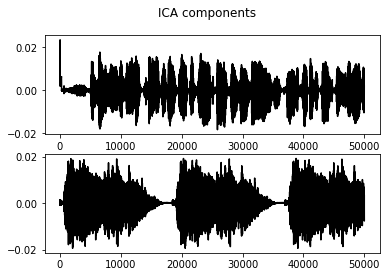

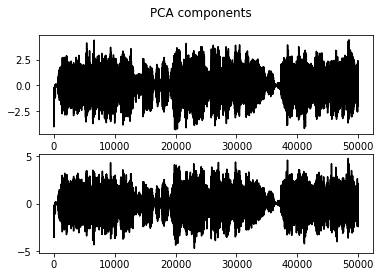

In [15]:
# plot ICA components
f, (ax1,ax2)=plt.subplots(2,1)

ax1.plot(S_[:,0],'k')
ax2.plot(S_[:,1],'k')
f.suptitle('ICA components')

# plot source signals
f, (ax1,ax2)=plt.subplots(2,1)

ax1.plot(H[:,0],'k')
ax2.plot(H[:,1],'k')
f.suptitle('PCA components')


Which approach does a better job?

## Biomedical case study: applying ICA to fMRI data

We finish by showing how ICA is most frequently used in biomedical imaging: for identifying patterns of brain activity from functional Magnetic Resonance Imaging (fMRI).

Generic MRI generates contrast by taking advantage of the fact that different tissues in the body have differing magnetic properties. This is related to the magnetisation of the water molecules, and reflects the differing proportions of water in different tissues, as well as their varying patterns of diffusion.

fMRI goes further to utlise the fact that oxygenated and de-oxygenated blood have different magnetic properties, and oxygenated blood flow in the brain is required to supply energy for neuronal firing. Differences in fMRI contrast due to the influx and uptake of oxygen are referred to ask Blood Oxygenated Level Dependent (BOLD) contrast.

An exemplar movie of temporally evolving BOLD contrast on the brain's surface is shown below:

In [ ]:
import io
import base64
from IPython.display import HTML


HTML("""
<video width="500" height="250" controls>
  <source src="imgs/fMRI.mp4" type="video/mp4">
</video>
""")

Here, yellow represents 'active' brain regions and blue 'deactivated' regions. Each point on the brain, therefore, can be represented by a timeseries of brain activity:
<br>


<img src="imgs/brain_and_timeseries.png" style="max-width:100%; width: 30%; max-width: none">

There is a saying in fMRI that 'what wires together, fires together'. In other words we assume that there are a relatively small number of brain regions (below left), that each have a common pattern of brain activity (or temporal signature): 

<br>

<img src="imgs/parcellation_and_network.png" style="max-width:100%; width: 50%; max-width: none">
<br>


These regions can be found by clustering points with common timeseries. Correlation between the temporal signatures of different regions allows inference of the connectional structure of the brain (above right). In other words we assume that if regions follow similar patterns of activity they must be connected via physical neuronal pathways, which enable them to communicate and coordinate with one another.

ICA can be used to find these regions, by separating out clusters of points on the surface with common timeseries. 

<br>

<img src="imgs/fMRIICA.png" style="max-width:100%; width: 60%; max-width: none">

<br> 

In fMRI spatial-ICA is used this means that the algorithm is looking for a series of independent 'spatial maps'. The maps (as shown below) represent regions with common timeseries, where yellow regions represent the cluster(s) of points, identified bvy the algorithm as having a common pattern of activity. Each spatial map is then associated with a timecourse (obtained from the columns of $\mathbf{A}$):

<br>

<img src="imgs/ICAcomponents.png" style="max-width:100%; width: 60%; max-width: none">

From this, regions and time courses can be used to build simple ’network’ models of the brain. Network models of fMRI imaging data have been shown to characterise different aspects of behaviour, cognition and disease.


## Summary

- PCA decomposition rotates data into a new basis that better reflects sources of variance in the data, where PCA components may be estimated from:
  - Eigen-decomposition of the data covariance matrix or
  - Singular Value Decomposition
- ICA allows un-mixing of signals and is estimated using pre-whitening and FastICA
- Both methods allow dimensionality reduction of the data 

- PCA has applications in:
 - biomedical shape modelling
 - image classification
 - Image denoising 
- ICA is commonly used to derive brain networks from fMRI


## References

[Hyv2000] Hyvärinen, Aapo, and Erkki Oja. "Independent component analysis: algorithms and applications." Neural networks 13.4-5 (2000): 411-430.

